# Simulating Heston Model in Python

<b> YouTube Tutorial </b> (Published:
Mar 18, 2022): https://youtu.be/o8C6DxZh8dw

### 1993: Stochastic volatility model by Heston

The Heston model is a useful model for simulating stochastic volatility and its effect on the potential paths an asset can take over the life of an option.
 - Popular because of easy closed-form solution for European option pricing
 - no risk of negative variances
 - incorporation of leverage effect

This allows for more effective modeling than the Black-Scholes formula allows due to its restrictive assumption of constant volatility.

### Heston Model SDE
The heston model is defined by a system of SDEs, to describe the movement of asset prices, where an
asset’s price and volatility follow random, Brownian motion processes (this is under real world measure $\mathbb{P}$):

<center>$\large dS_t = \mu S_t dt + \sqrt{v_t}S_t dW^\mathbb{P}_{S,t}$</center>
    
<center>$\large dv_t = \kappa(\theta - v_t)dt +\sigma \sqrt{v_t} dW^\mathbb{P}_{v,t}$</center>

Where the variables are:
- $\sigma$ volatility of volatility
- $\theta$ long-term price variance
- $\kappa$ rate of reversion to the long-term price variance
- $dW^\mathbb{P}_{S,t}$ Brownian motion of asset price
- $dW^\mathbb{P}_{v,t}$ Brownian motion of asset's price variance
- $\rho^\mathbb{P}$ correlation between $dW^\mathbb{P}_{S,t}$ and $dW^\mathbb{P}_{v,t}$

Dynamics under risk-neutral measure $\mathbb{Q}$:

<center>$\large dS_t = r S_t dt + \sqrt{v_t}S_t dW^\mathbb{Q}_{S,t}$</center>
    
<center>$\large dv_t = \kappa^\mathbb{Q}(\theta^\mathbb{Q} - v_t)dt +\sigma^\mathbb{Q} \sqrt{v_t} dW^\mathbb{Q}_{v,t}$</center>

### Heston Model for Monte Carlo Simulations

Obviously as discussed one of the nice things about the Heston model for European option prices is that there is a closed-form solution once you have the characteristic function. So discretisation of the SDE is not required for valuing a European option, however if you would like to value other option types with complex features using the Heston model than you can use the following code:

#### Euler Discretisation of SDEs
Great resource for explanation here: Euler and Milstein Discretization by Fabrice Douglas Rouah https://frouah.com/finance%20notes/Euler%20and%20Milstein%20Discretization.pdf
<center>$\Large dS_{i+1} = S_i e^{(r-\frac{v_i}{2}) \Delta t + \sqrt{v_{i}}\Delta tW^\mathbb{Q}_{S,i+1}}$</center>
    
<center>$\large v_{i+1} = v_i + \kappa(\theta - v_t)\Delta t +\sigma \sqrt{v_i} \Delta t W^\mathbb{Q}_{v,i+1}$</center>

In [2]:
!pip install py_vollib_vectorized

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 5.4 MB/s eta 0:00:00
  Created wheel for py-vollib: filename=py_vollib-1.0.1-py3-none-any.whl size=62829 sha256=01201ffde60171cc7ebbfda08036377c634736aa0095706633689cda9d13082f
  Stored in directory: /root/.cache/pip/wheels/84/0c/fc/b68506eda40cccaeb0013be550ba904d253ec90eae2b156052
  Created wheel for py-lets-be-rational: filename=py_lets_be_rational-1.0.1-py3-none-any.whl size=24450 sha256=c9192b5e2757147e609e0d3ef0a68562307a2253d64d9bb49d89e83308d78c92
  Stored in directory: /root/.cache/pip/wheels/32/d9/4f/360d4b0b9ec7c65583ec7c8e72fd2158c97ad04fbcb932891c
Successfully built py-vollib py-lets-be-rational


In [ ]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


#### Import Dependencies

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from py_vollib_vectorized import vectorized_implied_volatility as implied_vol

/usr/local/lib/python3.10/dist-packages/py_lets_be_rational/numba_helper.py:10: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  return jit(*jit_args, **jit_kwargs)(fun)


#### Define Parameters
Here we just define the parameters of the model under risk-neutral dynamics, however in a following tutorial I will show how to calibrate Heston model parameters under risk-neutral dynamics to real option market prices.

In [4]:
# Parameters
# simulation dependent
S0 = 100.0             # asset price
T = 1.0                # time in years
r = 0.02               # risk-free rate
N = 252                # number of time steps in simulation
M = 1000               # number of simulations

# Heston dependent parameters
kappa = 3              # rate of mean reversion of variance under risk-neutral dynamics
theta = 0.20**2        # long-term mean of variance under risk-neutral dynamics
v0 = 0.25**2           # initial variance under risk-neutral dynamics
rho = 0.7              # correlation between returns and variances under risk-neutral dynamics
sigma = 0.6            # volatility of volatility

theta, v0

(0.04000000000000001, 0.0625)

#### Monte Carlo Simulation
Because we have a recursive function, we have to step through time within our simulation. However we can simulate the Brownian motions of the asset and variances outside of the for loop.

In [5]:
def heston_model_sim(S0, v0, rho, kappa, theta, sigma,T, N, M):
    """
    Inputs:
     - S0, v0: initial parameters for asset and variance
     - rho   : correlation between asset returns and variance
     - kappa : rate of mean reversion in variance process
     - theta : long-term mean of variance process
     - sigma : vol of vol / volatility of variance process
     - T     : time of simulation
     - N     : number of time steps
     - M     : number of scenarios / simulations

    Outputs:
    - asset prices over time (numpy array)
    - variance over time (numpy array)
    """
    # initialise other parameters
    dt = T/N
    mu = np.array([0,0])
    cov = np.array([[1,rho],
                    [rho,1]])

    # arrays for storing prices and variances
    S = np.full(shape=(N+1,M), fill_value=S0)
    v = np.full(shape=(N+1,M), fill_value=v0)

    # sampling correlated brownian motions under risk-neutral measure
    Z = np.random.multivariate_normal(mu, cov, (N,M))

    for i in range(1,N+1):
        S[i] = S[i-1] * np.exp( (r - 0.5*v[i-1])*dt + np.sqrt(v[i-1] * dt) * Z[i-1,:,0] )
        v[i] = np.maximum(v[i-1] + kappa*(theta-v[i-1])*dt + sigma*np.sqrt(v[i-1]*dt)*Z[i-1,:,1],0)

    return S, v

In [6]:
rho_p = 0.98
rho_n = -0.98

S_p,v_p = heston_model_sim(S0, v0, rho_p, kappa, theta, sigma,T, N, M)
S_n,v_n = heston_model_sim(S0, v0, rho_n, kappa, theta, sigma,T, N, M)

#### Plotting the asset prices and variance over time

In [18]:
mu = 0.0

In [16]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import norm
import matplotlib.pyplot as plt

# Функция симуляции цен акций по модели Heston
def simulate_heston(S0, v0, kappa, theta, sigma, rho, mu, r, T, N, M):
    dt = T / N
    prices = np.zeros((N + 1, M))
    prices[0] = S0
    variances = np.zeros((N + 1, M))
    variances[0] = v0

    for t in range(1, N + 1):
        z1 = np.random.normal(size=M)
        z2 = rho * z1 + np.sqrt(1 - rho**2) * np.random.normal(size=M)

        variances[t] = variances[t - 1] + kappa * (theta - variances[t - 1]) * dt + sigma * np.sqrt(variances[t - 1] * dt) * z2
        prices[t] = prices[t - 1] * np.exp((mu - 0.5 * variances[t - 1]) * dt + np.sqrt(variances[t - 1] * dt) * z1)

    return prices, variances

# Функция правдоподобия для оценки параметров
def negative_log_likelihood(params, log_returns, dt):
    kappa, theta, sigma, rho, v0, mu = params
    m = len(log_returns)

    variances = np.zeros(m)
    variances[0] = v0

    for t in range(1, m):
        z = np.random.normal()
        variances[t] = variances[t - 1] + kappa * (theta - variances[t - 1]) * dt + sigma * np.sqrt(variances[t - 1] * dt) * z

    log_likelihood = -0.5 * (np.log(2 * np.pi * variances[1:] * dt) + ((log_returns[1:] - (mu - 0.5 * variances[1:]) * dt)**2) / (variances[1:] * dt)).sum()

    return -log_likelihood

# Функция оптимизации и нахождения параметров
def calibrate_heston_model(prices, T, r):
    returns = prices.pct_change().dropna().values
    log_returns = np.log(returns + 1)

    # Значения Dt для последовательности цен
    dt = 1 / 252  # допустим, у нас 252 торговых дня в году
    mu_estimate = returns.mean() / dt

    initial_guess = [3.0, 0.04, 0.6, -0.7, 0.04, mu_estimate]
    bounds = [(0.01, 10), (0.01, 1), (0.01, 2), (-0.99, 0.99), (0.01, 1), (None, None)]

    result = minimize(negative_log_likelihood, initial_guess, args=(log_returns, dt), method='L-BFGS-B', bounds=bounds)
    kappa_opt, theta_opt, sigma_opt, rho_opt, v0_opt, mu_opt = result.x

    return kappa_opt, theta_opt, sigma_opt, rho_opt, v0_opt, mu_opt
# Пример использования
# Допустим, у вас есть исторические цены актива в виде pandas Series
np.random.seed(42)

# Генерация примерных данных
#dates = pd.date_range(start='2020-01-01', end='2020-12-31', freq='B')
#prices_example = pd.Series(np.random.lognormal(mean=0.0, sigma=0.01, size=len(dates)), index=dates)

# Генерация дат
dates = pd.date_range(start='2020-01-01', periods=len(S_p[1]), freq='B')

# Создание pandas Series для цен
prices_example = pd.Series(S_p[1], index=dates)

# Калибровка параметров модели Heston на данных
kappa_opt, theta_opt, sigma_opt, rho_opt, v0_opt, mu_opt = calibrate_heston_model(prices_example, T=1, r=0.02)
print(f'Optimized Parameters:\n'
      f'kappa: {kappa_opt}\n'
      f'theta: {theta_opt}\n'
      f'sigma: {sigma_opt}\n'
      f'rho: {rho_opt}\n'
      f'v0: {v0_opt}\n'
      f'mu: {mu_opt}')

<ipython-input-16-5c6628e1a3fa>:34: RuntimeWarning: invalid value encountered in sqrt
  variances[t] = variances[t - 1] + kappa * (theta - variances[t - 1]) * dt + sigma * np.sqrt(variances[t - 1] * dt) * z
<ipython-input-16-5c6628e1a3fa>:36: RuntimeWarning: invalid value encountered in log
  log_likelihood = -0.5 * (np.log(2 * np.pi * variances[1:] * dt) + ((log_returns[1:] - (mu - 0.5 * variances[1:]) * dt)**2) / (variances[1:] * dt)).sum()


Optimized Parameters:
kappa: 3.0
theta: 0.04
sigma: 0.6
rho: -0.7
v0: 0.04
mu: 0.057715606946979935


In [22]:
# Создание DataFrame для сравнения параметров
params_comparison = pd.DataFrame({
    'Parameter': ['kappa', 'theta', 'sigma', 'rho', 'v0', 'mu'],
    'Real': [kappa, theta, sigma, rho, v0, mu],
    'Optimized': [kappa_opt, theta_opt, sigma_opt, rho_opt, v0_opt, mu_opt]
})

params_comparison['abs_diff']=abs(params_comparison['Real']-params_comparison['Optimized']).round(2)
params_comparison['diff_%']=(100*abs(params_comparison['Real']-params_comparison['Optimized'])/params_comparison['Real']).round(2)
params_comparison

,Parameter,Real,Optimized,abs_diff,diff_%
0,kappa,3.0000,3.000000,0.00,0.0
1,theta,0.0400,0.040000,0.00,0.0
2,sigma,0.6000,0.600000,0.00,0.0
3,rho,0.7000,-0.700000,1.40,200.0
4,v0,0.0625,0.040000,0.02,36.0
5,mu,0.0000,0.057716,0.06,inf


In [9]:
S_p[1]

array([100.53851129, 101.88527035,  97.74210199, 100.82310731,
        98.25863291, 104.72312894, 100.77610336, 102.58925728,
        97.56145911, 100.45308959, 101.19073901, 100.18471942,
       101.1320443 , 102.59698307,  98.21805935,  99.39894526,
        98.62703763,  99.8051882 , 100.71999629, 102.42923364,
       100.10195403, 100.06651792,  99.39183345,  99.85159416,
       101.02481388,  98.41374381,  98.18720033, 101.17929287,
       101.47276973,  99.4070385 ,  98.20445236, 102.3957018 ,
       100.24451441, 100.05286332, 101.51595764,  99.65284611,
       100.66862718,  98.69460291, 100.55838614, 101.71290125,
        99.11902862,  97.05952913,  98.31060219, 100.01797385,
        99.03451954, 103.19200011,  99.16858466,  97.24727796,
        99.63376368,  98.99125079,  99.53631796, 101.33771634,
       102.77300224, 101.26903776, 100.87801095, 100.8906386 ,
        97.1278325 ,  97.01647812, 100.9598685 , 102.05195869,
        98.756677  ,  99.4091972 ,  99.2036053 ,  99.46

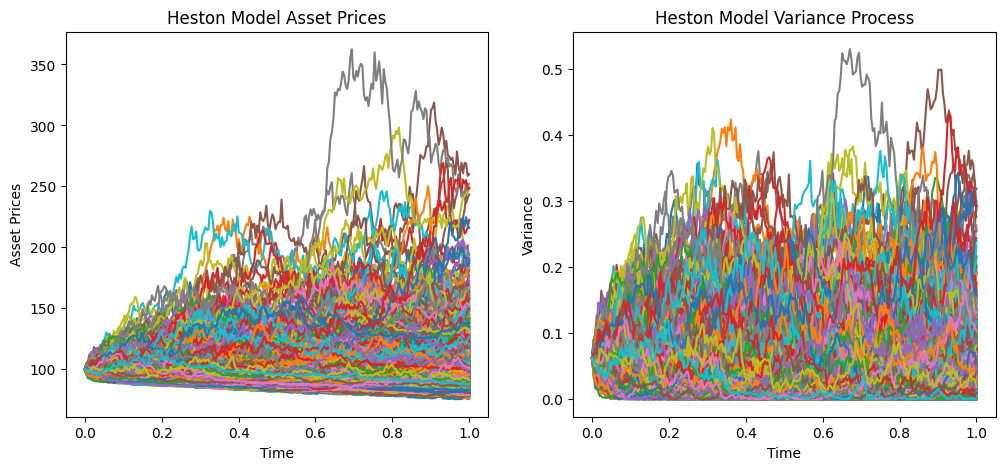

In [ ]:
fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(12,5))
time = np.linspace(0,T,N+1)
ax1.plot(time,S_p)
ax1.set_title('Heston Model Asset Prices')
ax1.set_xlabel('Time')
ax1.set_ylabel('Asset Prices')

ax2.plot(time,v_p)
ax2.set_title('Heston Model Variance Process')
ax2.set_xlabel('Time')
ax2.set_ylabel('Variance')

plt.show()

### Asset price distribution with different correlations

In [ ]:
# simulate gbm process at time T
gbm = S0*np.exp( (r - theta**2/2)*T + np.sqrt(theta)*np.sqrt(T)*np.random.normal(0,1,M) )

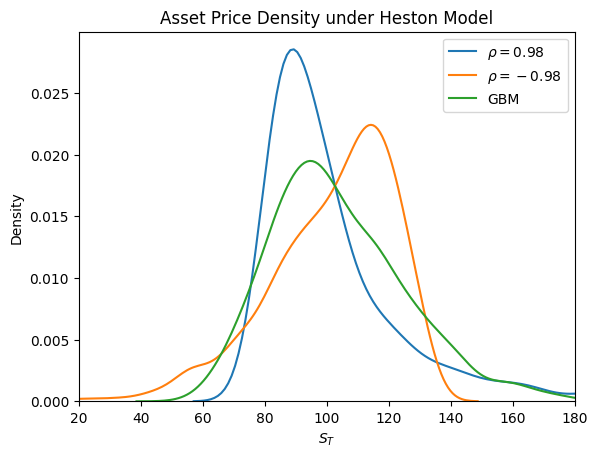

In [ ]:
fig, ax = plt.subplots()

ax = sns.kdeplot(S_p[-1], label=r"$\rho= 0.98$", ax=ax)
ax = sns.kdeplot(S_n[-1], label=r"$\rho= -0.98$", ax=ax)
ax = sns.kdeplot(gbm, label="GBM", ax=ax)

plt.title(r'Asset Price Density under Heston Model')
plt.xlim([20, 180])
plt.xlabel('$S_T$')
plt.ylabel('Density')
plt.legend()
plt.show()

### Capturing the Volatililty Smile in Option Pricing

In [ ]:
rho = -0.7
S,v = heston_model_sim(S0, v0, rho, kappa, theta, sigma,T, N, M)

In [ ]:
# Set strikes and complete MC option price for different strikes
K = np.arange(20,180,2)

puts = np.array([np.exp(-r*T)*np.mean(np.maximum(k-S,0)) for k in K])
calls = np.array([np.exp(-r*T)*np.mean(np.maximum(S-k,0)) for k in K])

put_ivs = implied_vol(puts, S0, K, T, r, flag='p', q=0, return_as='numpy', on_error='ignore')
call_ivs = implied_vol(calls, S0, K, T, r, flag='c', q=0, return_as='numpy')

/Users/silach53/Desktop/investment-portfolio-optimizer/venv/lib/python3.11/site-packages/py_vollib_vectorized/implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
  below_intrinsic, above_max_price = _check_below_and_above_intrinsic(K, F, flag, undiscounted_option_price, on_error)


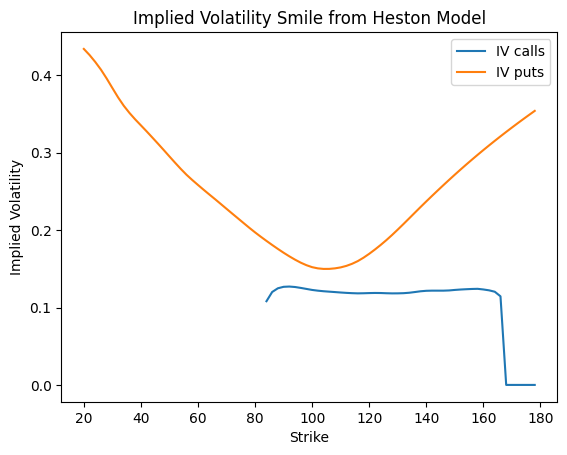

In [ ]:
plt.plot(K, call_ivs, label=r'IV calls')
plt.plot(K, put_ivs, label=r'IV puts')

plt.ylabel('Implied Volatility')
plt.xlabel('Strike')

plt.title('Implied Volatility Smile from Heston Model')
plt.legend()
plt.show()